# Subreddit Stats

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as md
import numpy as np
import praw
from psaw import PushshiftAPI
import datetime
import yaml
import time
from sortedcontainers import SortedDict
from collections import OrderedDict

## Parameters

In [2]:
start_epoch = int(datetime.datetime(2018, 1, 1).timestamp())
start_subs = 680       # number of subs at start_epoch (needed if before 2018/3/15, see redditmetrics.com)
#end_epoch = int(datetime.datetime(2019, 1, 1).timestamp())
end_epoch = int(time.time())
max_posts = 10000      # max number of posts to crawl, None for unlimited
sub = 'dreamcatcher'   # subreddit to crawl

## Get Data

In [3]:
class Comment:
    def __init__(self):
        self.body = ''
        self.author = ''
        self.score = 0
        self.ts = 0
        self.url = ''

class Post:
    def __init__(self):
        self.title = ''
        self.author = ''
        self.ts = 0
        self.score = 0
        self.comments = []
        self.url = ''

In [4]:
stream = open('client_info.txt', 'r')
doc = yaml.load(stream)

r = praw.Reddit(client_id=doc['client_id'],
                client_secret=doc['client_secret'],
                user_agent='test'
                )
api_ps_praw = PushshiftAPI(r)
api_ps = PushshiftAPI()
post_ids = api_ps_praw.search_submissions(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=sub,
                                  filter=['url', 'author', 'title', 'subreddit'],
                                  limit=max_posts)
subs = api_ps.search_submissions(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=sub,
                                  filter=['subreddit', 'id', 'subreddit_subscribers'],
                                  limit=max_posts)
id2subs = {}

for s in subs:
    if hasattr(s, 'subreddit_subscribers'):
        num_subs = s.subreddit_subscribers
    else:
        num_subs = -1    
    id2subs[s.id] = num_subs
            
subcount_temp = SortedDict()
posts = []
prev_info_len = 1

for i, post_id in enumerate(post_ids):
    submission = praw.models.Submission(r, id=post_id)
    ts = int(submission.created_utc)
    subcount_temp[ts] = id2subs[post_id.id]
    submission.comments.replace_more()
    comment_ids = submission.comments.list()
    c = []
    
    for comment_id in comment_ids:
        comment = praw.models.Comment(r, id=comment_id)
        temp = Comment()
        temp.body = comment.body
        temp.author = comment.author
        temp.ts = comment.created_utc
        temp.score = comment.score
        temp.url = comment.permalink
        c.append(temp)
    
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    temp = Post()
    temp.title = submission.title
    temp.author = submission.author
    temp.ts = submission.created_utc
    temp.score = submission.score
    temp.comments = c
    temp.url = submission.permalink
    posts.append(temp)
    
    title = (temp.title[:47] + '...') if len(temp.title) > 47 else temp.title
    info = '%05d: %s --- %s' % (i, ts_str, title)
    clear = ' ' * prev_info_len
    print('%s' % clear, end='\r', flush=True)
    prev_info_len = len(info)
    print('%s' % info, end='\r', flush=True)
    
num_posts = i+1
    
print('\ndone')

03298: 2018-01-01 15:20:23 --- Dreamcatcher end of year awards                   ..
done


## Visualize Data

### Subscriber Growth

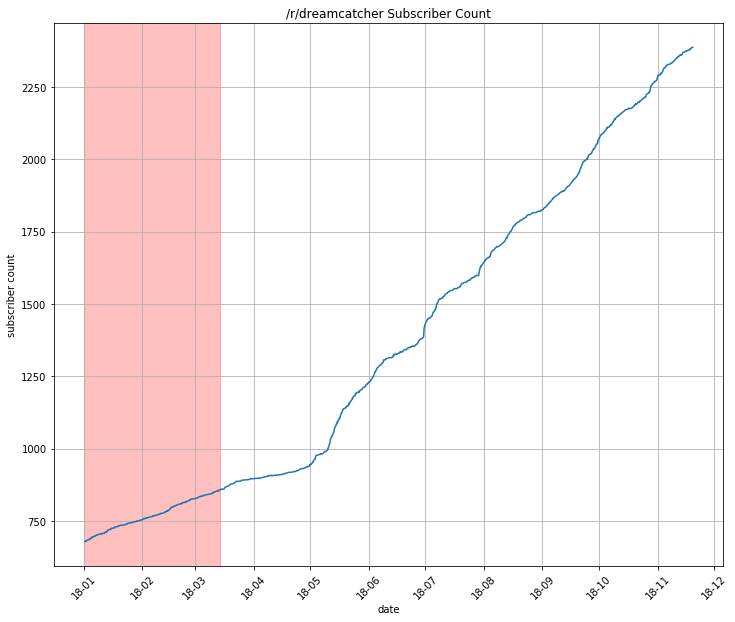

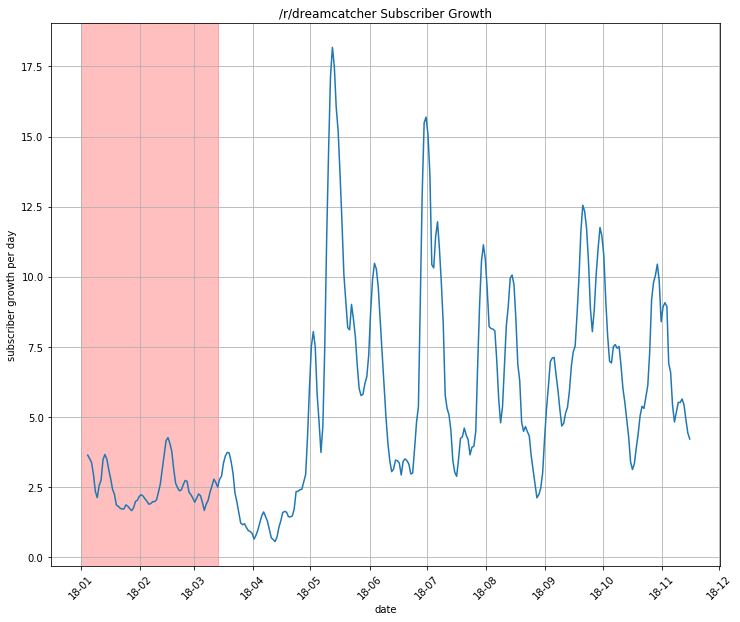

In [8]:
# fix (interpolate) bad sub count data
timestamps = np.zeros(len(subcount_temp))
subs = np.zeros(len(subcount_temp))
no_sub_data_end = -1
for i, ts in enumerate(subcount_temp):
    timestamps[i] = ts
    subs[i] = subcount_temp[ts]
    if subs[i] == -1:
        no_sub_data_end = i
        
if start_subs is not None:
    if no_sub_data_end < len(subs)+1:
        subs[:no_sub_data_end+1] = np.floor(np.linspace(start_subs, subs[no_sub_data_end+1], no_sub_data_end+1))
        
start_epoch_date = datetime.datetime.fromtimestamp(start_epoch)
no_sub_data_end_date = datetime.datetime.fromtimestamp(timestamps[no_sub_data_end])


subcount = SortedDict()
for i, s in enumerate(subs):
    subcount[timestamps[i]] = s

# sub count
        
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
    
plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, subs)
plt.axvspan(start_epoch_date, no_sub_data_end_date, color='red', alpha=0.25)
plt.xlabel('date')
plt.ylabel('subscriber count')
plt.title('/r/%s Subscriber Count' % (sub))
plt.grid(b=True, which='both', axis='both')

# sub growth

secs_in_day = 86400

ts_begin = start_epoch
ts_end = 7 * secs_in_day + ts_begin # days after ts_begin

sub_growth_ts = []
sub_growth = []
while ts_end < end_epoch:
    it = subcount.irange(ts_begin, ts_end)
    temp_ts = []
    temp_subcount = []
    for ts in it:
        temp_ts.append(ts)
        temp_subcount.append(subcount[ts])
    if len(temp_ts) != 0:
        p_fit = np.polyfit(temp_ts, temp_subcount, 1)
        sub_growth_ts.append((ts_begin + ts_end)/2)
        sub_growth.append(p_fit[0])
    ts_begin += secs_in_day
    ts_end += secs_in_day

dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in sub_growth_ts])
sub_growth = np.array(sub_growth) * secs_in_day

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, sub_growth)
plt.axvspan(start_epoch_date, no_sub_data_end_date, color='red', alpha=0.25)
plt.xlabel('date')
plt.ylabel('subscriber growth per day')
plt.title('/r/%s Subscriber Growth' % (sub))
plt.grid(b=True, which='both', axis='both')

plt.show()

### Post and Comment Frequency

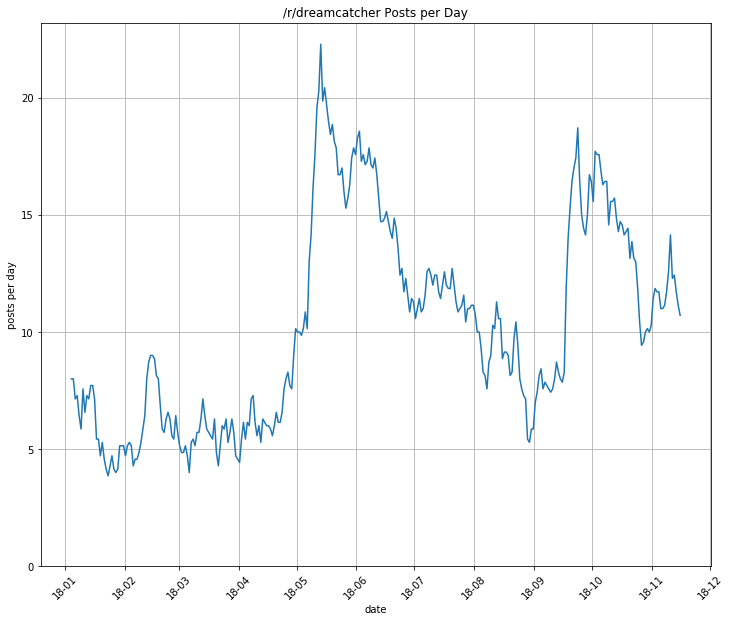

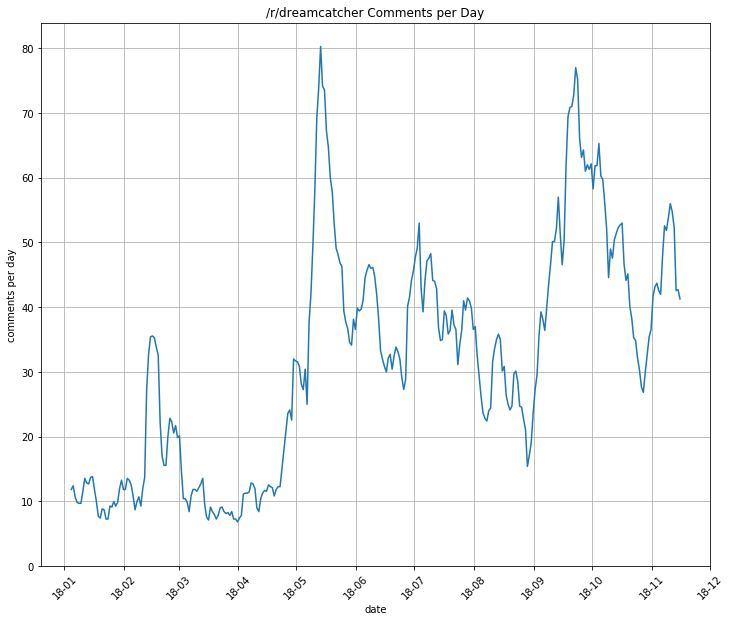

In [9]:
kernel_size = 7

# sort posts by time stamp
chron_posts = SortedDict()

for post in posts:
    chron_posts[post.ts] = post
    
    
# posts per day
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

post_freq_ts = []
post_freq = []
while ts_end < end_epoch:
    it = chron_posts.irange(ts_begin, ts_end)
    count = 0
    for ts in it:
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        post_freq_ts.append(ts)
        post_freq.append(count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in post_freq_ts])
post_freq = np.array(post_freq) / kernel_size

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, post_freq)
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('posts per day')
plt.title('/r/%s Posts per Day' % (sub))
plt.grid(b=True, which='both', axis='both')


# comments per day

chron_comments = SortedDict()
for post in posts:
    for comment in post.comments:
        chron_comments[comment.ts] = comment

ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

comment_freq_ts = []
comment_freq = []
while ts_end < end_epoch:
    it = chron_comments.irange(ts_begin, ts_end)
    count = 0
    for ts in it:
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        comment_freq_ts.append(ts)
        comment_freq.append(count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in post_freq_ts])
comment_freq = np.array(comment_freq) / kernel_size

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, comment_freq)
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('comments per day')
plt.title('/r/%s Comments per Day' % (sub))
plt.grid(b=True, which='both', axis='both')

plt.show()

### Average Post and Comment Scores

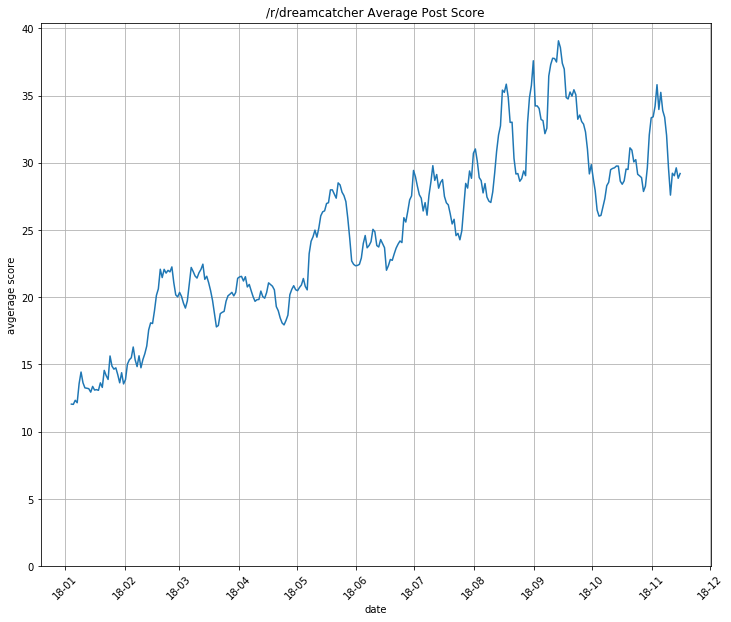

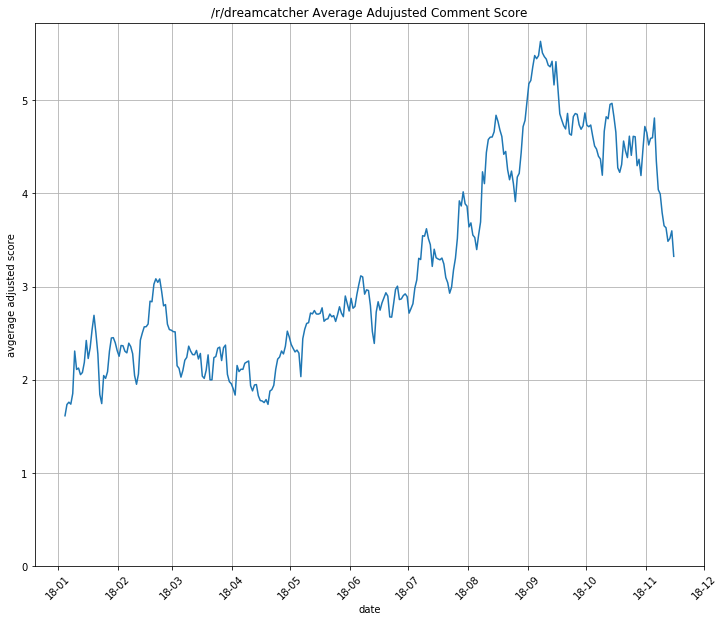

In [10]:
kernel_size = 7

# sort posts by time stamp
chron_posts = SortedDict()

for post in posts:
    chron_posts[post.ts] = post
    
    
# average post score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

post_avg_score_ts = []
post_avg_score = []
while ts_end < end_epoch:
    it = chron_posts.irange(ts_begin, ts_end)
    total_score = 0
    count = 0
    for ts in it:
        total_score += chron_posts[ts].score
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        post_avg_score_ts.append(ts)
        post_avg_score.append(total_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in post_freq_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, post_avg_score)
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage score')
plt.title('/r/%s Average Post Score' % (sub))
plt.grid(b=True, which='both', axis='both')

# average comment score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

comment_avg_score_ts = []
comment_avg_score = []
while ts_end < end_epoch:
    it = chron_comments.irange(ts_begin, ts_end)
    total_adj_comment_score = 0
    count = 0
    for ts in it:
        total_adj_comment_score += chron_comments[ts].score
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        comment_avg_score_ts.append(ts)
        comment_avg_score.append(total_adj_comment_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in comment_avg_score_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, comment_avg_score)
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage adjusted score')
plt.title('/r/%s Average Adujusted Comment Score' % (sub))
plt.grid(b=True, which='both', axis='both')

plt.show()

### Make Score Adjustments

In [11]:
all_ts = np.zeros((len(chron_posts)))
all_scores = np.zeros((len(chron_posts)))

for i, ts in enumerate(chron_posts):
    all_ts[i] = ts
    all_scores[i] = chron_posts[ts].score
    
all_comment_ts = np.zeros((len(chron_comments)))
all_comment_scores = np.zeros((len(chron_comments)))

for i, ts in enumerate(chron_comments):
    all_comment_ts[i] = ts
    all_comment_scores[i] = chron_comments[ts].score
        
post_slope, _ = np.polyfit(all_ts, all_scores, 1)
comment_slope, _ = np.polyfit(all_comment_ts, all_comment_scores, 1)

def calc_adj(ts, score):
    return float(score - ts*post_slope + end_epoch*post_slope)

def calc_comment_adj(ts, score):
    return float(score - ts*comment_slope + end_epoch*comment_slope)

### Average Adjusted Post and Comment Scores

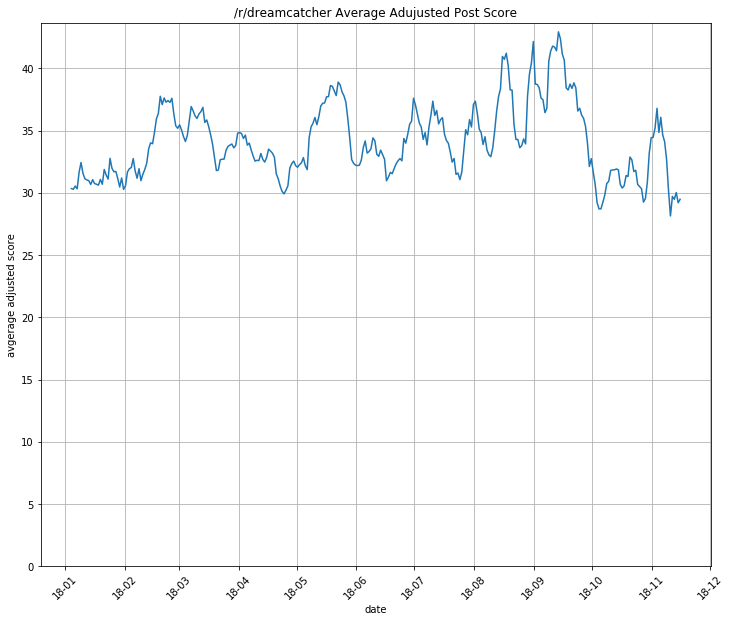

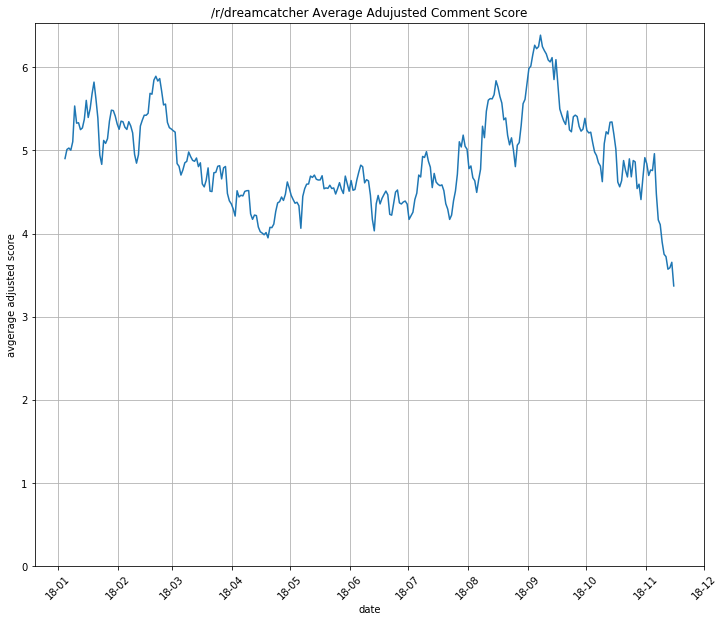

In [12]:
# average post score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

post_avg_score_ts = []
post_avg_score = []
while ts_end < end_epoch:
    it = chron_posts.irange(ts_begin, ts_end)
    total_adj_score = 0
    count = 0
    for ts in it:
        total_adj_score += calc_adj(ts, chron_posts[ts].score)
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        post_avg_score_ts.append(ts)
        post_avg_score.append(total_adj_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in post_avg_score_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, post_avg_score)
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage adjusted score')
plt.title('/r/%s Average Adujusted Post Score' % (sub))
plt.grid(b=True, which='both', axis='both')

# average comment score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

comment_avg_score_ts = []
comment_avg_score = []
while ts_end < end_epoch:
    it = chron_comments.irange(ts_begin, ts_end)
    total_adj_comment_score = 0
    count = 0
    for ts in it:
        total_adj_comment_score += calc_comment_adj(ts, chron_comments[ts].score)
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        comment_avg_score_ts.append(ts)
        comment_avg_score.append(total_adj_comment_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in comment_avg_score_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, comment_avg_score)
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage adjusted score')
plt.title('/r/%s Average Adujusted Comment Score' % (sub))
plt.grid(b=True, which='both', axis='both')

plt.show()

## Leaderboards

### Top Posts

In [13]:
adj_scores = np.zeros((len(posts)), dtype=float)
for i, post in enumerate(posts):
    ts = int(post.ts)
    adj_scores[i] = calc_adj(ts, post.score)


top_idx = (-adj_scores).argsort()[:10]

for i, idx in enumerate(top_idx):
    post = posts[idx]
    ts = int(post.ts)
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    print('top post #%d' % (i+1))
    print('title:          %s' % (post.title))
    print('author:         %s' % (post.author))
    print('time:           %s' % (ts_str))
    print('score:          %d' % (post.score))
    print('adjusted score: %f' % (calc_adj(post.ts, post.score)))
    print('comments:       %d' % (len(post.comments)))
    print('permalink:      https://www.reddit.com%s' % (post.url))
    print()

top post #1
title:          Dreamcatcher (드림캐쳐) - 'What' MV
author:         SpideyCyclist
time:           2018-09-20 09:00:45
score:          187
adjusted score: 190.480098
comments:       35
permalink:      https://www.reddit.com/r/dreamcatcher/comments/9hdotl/dreamcatcher_드림캐쳐_what_mv/

top post #2
title:          Dreamcatcher (드림캐쳐) - 'YOU AND I' MV
author:         SpideyCyclist
time:           2018-05-10 09:01:59
score:          174
adjusted score: 185.093736
comments:       15
permalink:      https://www.reddit.com/r/dreamcatcher/comments/8idh2r/dreamcatcher_드림캐쳐_you_and_i_mv/

top post #3
title:          The 'What' introduction is so awesome
author:         SpideyCyclist
time:           2018-09-21 10:08:01
score:          133
adjusted score: 136.420178
comments:       9
permalink:      https://www.reddit.com/r/dreamcatcher/comments/9ho5t2/the_what_introduction_is_so_awesome/

top post #4
title:          New Fans Guide To Dreamcatcher
author:         SpideyCyclist
time:           

### Top Comments

In [14]:
all_comments = []
comment_ts2post_ts = {}
for i, post in enumerate(posts):
    ts = int(post.ts)
    for comment in post.comments:
        all_comments.append(comment)
        if comment.ts not in comment_ts2post_ts:
            comment_ts2post_ts[comment.ts] = ts

adj_scores = np.zeros((len(all_comments)), dtype=float)
for i in range(len(all_comments)):
    ts = int(all_comments[i].ts)
    adj_scores[i] = calc_comment_adj(ts, all_comments[i].score)
    
top_idx = (-adj_scores).argsort()[:10]

for i, idx in enumerate(top_idx):
    comment = all_comments[idx]
    body = comment.body.replace('\n', ' ')
    body = (body[:97] + '...') if len(body) > 97 else body
    ts = int(comment.ts)
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    print('top comment #%d' % (i+1))
    print('comment:        %s' % (body))
    print('author:         %s' % (comment.author))
    print('time:           %s' % (ts_str))
    print('score:          %d' % (comment.score))
    print('adjusted score: %f' % (adj_scores[idx]))
    print('permalink:      https://www.reddit.com%s' % (comment.url))
    print()

top comment #1
comment:        Hi everyone,  International fans \- this day is dedicated to you. After working tirelessly with H...
author:         DCUnion-Astraea
time:           2018-06-01 11:29:20
score:          31
adjusted score: 32.765346
permalink:      https://www.reddit.com/r/dreamcatcher/comments/8nr4bi/eng_subs_available_on_dreamcatcher_videos/dzxndb0/

top comment #2
comment:        If Yoohyeon says it is down there by GOD IT IS DOWN THERE!
author:         dreamcatcherERA
time:           2018-09-24 13:19:44
score:          28
adjusted score: 28.582101
permalink:      https://www.reddit.com/r/dreamcatcher/comments/9ihm37/uh_yoohyeon_wrong_side/e6joug6/

top comment #3
comment:        I'm sure she'll be fine as soon as she stops screaming WHAT every time she see a camera.
author:         springbay
time:           2018-09-22 17:50:40
score:          27
adjusted score: 27.600731
permalink:      https://www.reddit.com/r/dreamcatcher/comments/9i0hxz/sua_is_suffering_from_vocal_co

### Top Posters

In [15]:
users = OrderedDict()
for i, post in enumerate(posts):
    ts = int(post.ts)
    if post.author == None:
        continue
    if post.author not in users:
        users[post.author] = {}
        users[post.author]['score'] = 0
        users[post.author]['adj_score'] = 0
        users[post.author]['posts'] = 0
        users[post.author]['comment_score'] = 0
        users[post.author]['adj_comment_score'] = 0
        users[post.author]['comments'] = 0
    users[post.author]['score'] += post.score
    users[post.author]['adj_score'] += calc_adj(ts, post.score)
    users[post.author]['posts'] += 1
    for comment in post.comments:
        if comment.author not in users:
            users[comment.author] = {}
            users[comment.author]['score'] = 0
            users[comment.author]['adj_score'] = 0
            users[comment.author]['posts'] = 0
            users[comment.author]['comment_score'] = 0
            users[comment.author]['adj_comment_score'] = 0
            users[comment.author]['comments'] = 0
        users[comment.author]['comment_score'] += comment.score
        users[comment.author]['adj_comment_score'] += calc_comment_adj(comment.ts, comment.score)
        users[comment.author]['comments'] += 1

In [16]:
sorted_posters = OrderedDict(sorted(users.items(), key=lambda x: x[1]['adj_score'], reverse=True))

for i, key in enumerate(sorted_posters):
    if i >= 10:
        break
    print('top poster #%d' % (i+1))
    print('user:                  %s' % (key))
    print('total number of posts: %d' % (sorted_posters[key]['posts']))
    print('total score:           %d' % (sorted_posters[key]['score']))
    print('total adjusted score:  %f' % (sorted_posters[key]['adj_score']))
    print()

top poster #1
user:                  SpideyCyclist
total number of posts: 2354
total score:           62444
total adjusted score:  82689.239570

top poster #2
user:                  myblindy
total number of posts: 71
total score:           3521
total adjusted score:  4271.600535

top poster #3
user:                  CDN_Datawraith
total number of posts: 84
total score:           2385
total adjusted score:  2848.908757

top poster #4
user:                  kyunikeon
total number of posts: 64
total score:           2577
total adjusted score:  2743.377511

top poster #5
user:                  GenghisKhaii
total number of posts: 40
total score:           1176
total adjusted score:  1387.987258

top poster #6
user:                  vagabond2787
total number of posts: 24
total score:           1020
total adjusted score:  1078.566371

top poster #7
user:                  Naienitsugua
total number of posts: 21
total score:           830
total adjusted score:  955.717702

top poster #8
user:   

## Top Commenters

In [17]:
sorted_commenters = OrderedDict(sorted(users.items(), key=lambda x: x[1]['adj_comment_score'], reverse=True))

for i, key in enumerate(sorted_commenters):
    if i >= 10:
        break
    print('top commenter #%d' % (i+1))
    print('user:                          %s' % (key))
    print('total number of comments:      %d' % (sorted_commenters[key]['comments']))
    print('total comment score:           %d' % (sorted_commenters[key]['comment_score']))
    print('total adjusted comment score:  %f' % (sorted_commenters[key]['adj_comment_score']))
    print()

top commenter #1
user:                          SpideyCyclist
total number of comments:      2836
total comment score:           8137
total adjusted comment score:  12410.335795

top commenter #2
user:                          internet0jesus
total number of comments:      958
total comment score:           4379
total adjusted comment score:  5250.661188

top commenter #3
user:                          dreamcatcherERA
total number of comments:      342
total comment score:           1385
total adjusted comment score:  1823.405342

top commenter #4
user:                          Darrens_Coconut
total number of comments:      244
total comment score:           1245
total adjusted comment score:  1450.861478

top commenter #5
user:                          ipwnmice
total number of comments:      209
total comment score:           961
total adjusted comment score:  1177.600402

top commenter #6
user:                          kyunikeon
total number of comments:      207
total comment score: 

## Top Average Users

In [18]:
temp = OrderedDict()
for user in users:
    if user not in temp:
        temp[user] = {}
        
    if users[user]['posts'] == 0:
        temp[user]['avg_adj_score'] = 0;
    else:
        temp[user]['avg_adj_score'] = users[user]['adj_score'] / users[user]['posts']
        
    if users[user]['comments'] == 0:
        temp[user]['avg_adj_comment_score'] = 0;
    else:
        temp[user]['avg_adj_comment_score'] = users[user]['adj_comment_score'] / users[user]['comments']


In [19]:
sorted_avg_posters = OrderedDict(sorted(temp.items(), key=lambda x: x[1]['avg_adj_score'], reverse=True))

i = 0;
for key in sorted_avg_posters:
    if i >= 10:
        break
    if users[key]['posts'] < 10:
        continue
    print('top avg poster #%d' % (i+1))
    print('user:                  %s' % (key))
    print('avg adjusted score:    %f' % (sorted_avg_posters[key]['avg_adj_score']))
    print('total number of posts: %d' % (users[key]['posts']))
    print('total score:           %d' % (users[key]['score']))
    print('total adjusted score:  %f' % (users[key]['adj_score']))
    print()
    i += 1

top avg poster #1
user:                  AmaryllisDC
avg adjusted score:    72.128338
total number of posts: 11
total score:           691
total adjusted score:  793.411714

top avg poster #2
user:                  myblindy
avg adjusted score:    60.163388
total number of posts: 71
total score:           3521
total adjusted score:  4271.600535

top avg poster #3
user:                  Naienitsugua
avg adjusted score:    45.510367
total number of posts: 21
total score:           830
total adjusted score:  955.717702

top avg poster #4
user:                  vagabond2787
avg adjusted score:    44.940265
total number of posts: 24
total score:           1020
total adjusted score:  1078.566371

top avg poster #5
user:                  kyunikeon
avg adjusted score:    42.865274
total number of posts: 64
total score:           2577
total adjusted score:  2743.377511

top avg poster #6
user:                  foxhound-delta
avg adjusted score:    38.825496
total number of posts: 13
total score:

In [20]:
sorted_avg_commenters = OrderedDict(sorted(temp.items(), key=lambda x: x[1]['avg_adj_comment_score'], reverse=True))

i = 0
for key in sorted_avg_commenters:
    if i >= 10:
        break
    if users[key]['comments'] < 30:
        continue
    print('top avg commenter #%d' % (i+1))
    print('user:                         %s' % (key))
    print('avg adjusted comment score:   %f' % (sorted_avg_commenters[key]['avg_adj_comment_score']))
    print('total number of comments:     %d' % (users[key]['comments']))
    print('total comment score:          %d' % (users[key]['comment_score']))
    print('total adjusted comment score: %f' % (users[key]['adj_comment_score']))
    print()
    i += 1

top avg commenter #1
user:                         IBrosiedon
avg adjusted comment score:   8.583733
total number of comments:     62
total comment score:          481
total adjusted comment score: 532.191425

top avg commenter #2
user:                         Yaong_
avg adjusted comment score:   7.214839
total number of comments:     32
total comment score:          186
total adjusted comment score: 230.874851

top avg commenter #3
user:                         VanRoyal
avg adjusted comment score:   6.359565
total number of comments:     44
total comment score:          204
total adjusted comment score: 279.820864

top avg commenter #4
user:                         Mark_Kostecki
avg adjusted comment score:   6.346685
total number of comments:     61
total comment score:          336
total adjusted comment score: 387.147764

top avg commenter #5
user:                         GenghisKhaii
avg adjusted comment score:   6.246622
total number of comments:     139
total comment score:      